In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_utils import get_dataframe, process_dataframe

# load data from firebase server
df = process_dataframe(get_dataframe("https://monitor-a80a5.firebaseio.com/"))
df.head()

[*] Opening connection to Firebase
[*] Converting python object to dataframe
[*] Writing engineered features to dataframe


,endTime,startTime,url,hostname,path,time
0,1518935096389,1518935096099,file:///home/keller/Documents/Github/TJ-habit-...,None,/home/keller/Documents/Github/TJ-habit-bot/fir...,290
1,1518935096651,1518935096406,chrome://extensions/,extensions,/,245
2,1518935097536,1518935097333,chrome://extensions/,extensions,/,203
3,1518935097819,1518935097554,https://console.firebase.google.com/u/0/projec...,console.firebase.google.com,/u/0/project/monitor-a80a5/database/monitor-a8...,265
4,1518935097957,1518935097822,file:///home/keller/Documents/Github/TJ-habit-...,None,/home/keller/Documents/Github/TJ-habit-bot/fir...,135


In [25]:
hostname_counts = df['hostname'].value_counts()
hostname_times = pd.Series()
for i in range(len(df)):
    row = df.iloc[i]
    hostname = row['hostname']
    if hostname in hostname_times.keys():
        hostname_times[hostname] += row['time']
    else:
        hostname_times[hostname] = row['time']
hostname_times = hostname_times.sort_values(ascending=False)

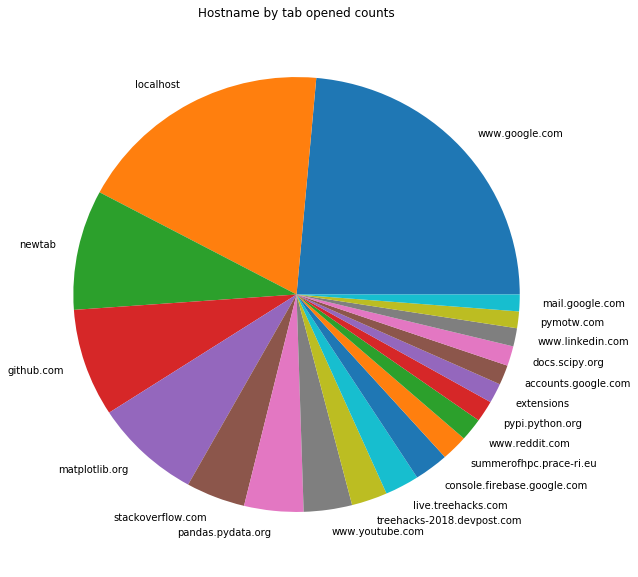

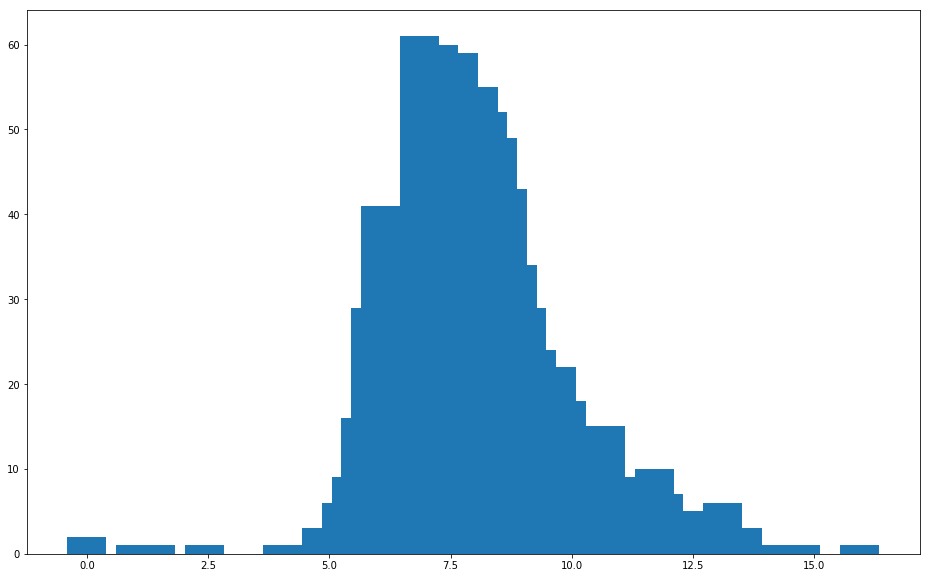

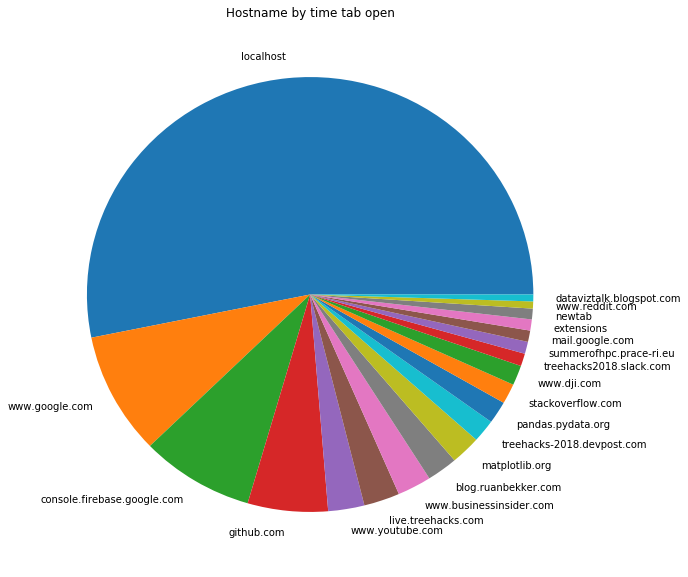

hostname_counts variance:  4.7214429136
hostname_times variance:  16.3088148828

localhost                      19779843
www.google.com                  3377031
console.firebase.google.com     3057432
github.com                      2159866
www.youtube.com                  975330
live.treehacks.com               965605
www.businessinsider.com          914699
blog.ruanbekker.com              827870
matplotlib.org                   806042
treehacks-2018.devpost.com       625647
dtype: int64


In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(hostname_counts.values[:20], labels=hostname_counts.keys()[:20])
plt.title('Hostname by tab opened counts')

# the log of time spent on a tab is distributed like so
times = df['time'].as_matrix()
hist, bins = np.histogram(np.log(times+1), bins=80)
fig, ax = plt.subplots(figsize=(16, 10))
ax.bar(bins[:-1], hist)

# observe the difference between `newtab` in this vs the previous
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(hostname_times.values[:20], labels=hostname_times.keys()[:20])
plt.title('Hostname by time tab open')

plt.show()

print('hostname_counts variance: ', (hostname_counts.values / hostname_counts.values.mean()).var())
print('hostname_times variance: ', (hostname_times.values / hostname_times.values.mean()).var())
print()
print(hostname_times[:10])

In [29]:
top_count = 25
top_hostnames = df['hostname'].value_counts()[:top_count-1]
top_hostnames['<OTHER>'] = len(df) - top_hostnames.values.sum()

# coocurrence[i][j] := expected number of  js in the next w tabs after an i

coocurrence = np.zeros((top_count, top_count))

def get_index(hostname):
    if hostname in top_hostnames.keys()[:-1]:
        return top_hostnames.keys().get_loc(hostname)
    else:
        return len(top_hostnames.keys()) - 1

w = 20 # window size
for src in range(len(df)):
    i = get_index(df.iloc[src]['hostname'])
    for dst in range(src, min(src+w, len(df)-w)):
        j = get_index(df.iloc[dst]['hostname'])
        coocurrence[i, j] += 1

for i in range(top_count):
    coocurrence[i] /= top_hostnames[i]

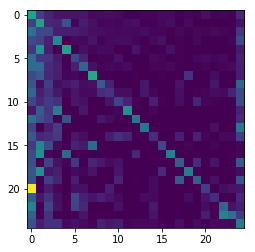

0 www.google.com
1 localhost
2 newtab
3 github.com
4 matplotlib.org
5 stackoverflow.com
6 pandas.pydata.org
7 www.youtube.com
8 treehacks-2018.devpost.com
9 live.treehacks.com
10 console.firebase.google.com
11 summerofhpc.prace-ri.eu
12 www.reddit.com
13 pypi.python.org
14 extensions
15 accounts.google.com
16 docs.scipy.org
17 www.linkedin.com
18 pymotw.com
19 mail.google.com
20 calendar.google.com
21 docs.python.org
22 www.businessinsider.com
23 jvivian.github.io
24 <OTHER>


In [30]:
coocurrence_norm = coocurrence / coocurrence.mean(axis=1)
plt.imshow(coocurrence)
plt.show()

for pair in enumerate(top_hostnames.keys()):
    print(*pair)

In [12]:
TIME_MULT = 3600000

rows = []
start_time = df.iloc[0]['startTime']
for i in range(len(df)):
    entry = df.iloc[i]
    rows.append([(entry['startTime']-start_time)/TIME_MULT, entry['time']/TIME_MULT, entry['hostname']])

WORK_HOSTS = [
    'github.com',
    'matplotlib.org',
    'pandas.pydata.org',
    'stackoverflow.com',
    'console.firebase.google.com',
    'bokeh.pydata.org',
    'pymotw.com',
    'localhost',
    'www.google.com'
]
MEDIA_HOSTS = [
    'www.youtube.com',
    'www.reddit.com',
    'www.facebook.com',
    'www.businessinsider.com',
    'mail.google.com'
]

x_work, x_media, x_other = [], [], []
width_work, width_media, width_other = [], [], []
for row in rows:
    if row[2] in WORK_HOSTS:
        x_work.append(row[0])
        width_work.append(row[1])
    elif row[2] in MEDIA_HOSTS:
        x_media.append(row[0])
        width_media.append(row[1])
    else:
        x_other.append(row[0])
        width_other.append(row[1])

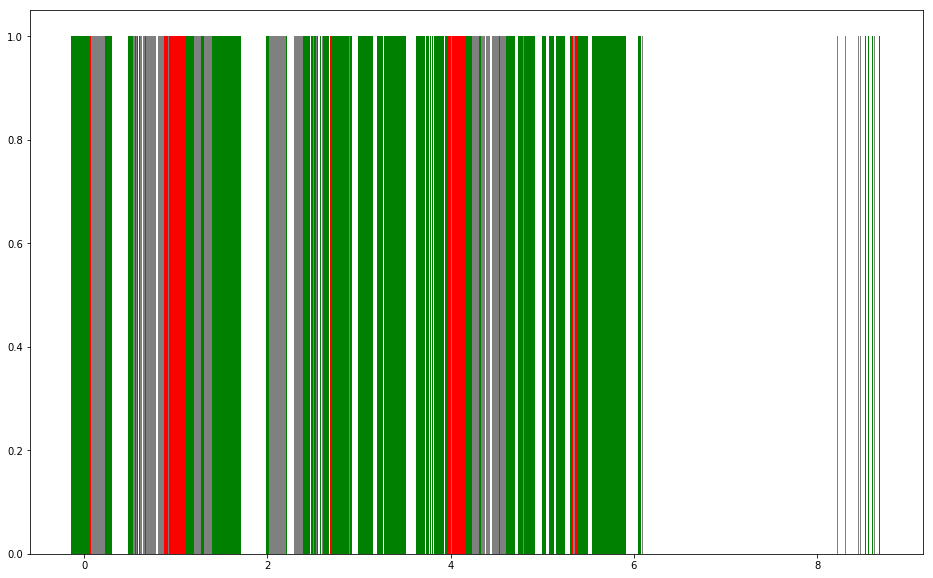

In [13]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.bar(x_work, [1]*len(x_work), width_work, color='green')
ax.bar(x_media, [1]*len(x_media), width_media, color='red')
ax.bar(x_other, [1]*len(x_other), width_other, color='gray')
plt.show()

In [18]:
print(sum(width_work))
print(sum(width_media))
print(sum(width_other))

5.62255583333
0.6842375
1.54533444444


### Sample Inference

You have labeled `www.facebook.com` and `www.youtube.com` as "distracting sites". We found that after visiting site `hackernews.ycombinator.com`, you then had an `86%` chance of visiting a distracting site in the next 20 tabs visited. Would you like to label `hackernews.ycombinator.com` as distracting?